In [171]:
import os
import time
import glob
import LatLon 
import numpy as np
import pandas as pd
from sklearn import metrics
from datetime import datetime
from matplotlib.dates import date2num
pd.set_option('display.max_rows', 10)

%matplotlib inline
import pylab
import geoplotlib
import seaborn as sns
sns.set_style("whitegrid")
from mpl_toolkits import basemap
from pysurvey.plot import setup, legend, icolorbar, density, text

In [2]:
filename = '/Users/ajmendez/tmp/ships/ships_clean.csv'
# shipdata.to_csv(filename)
shipdata = pd.read_csv(filename)

/Users/ajmendez/.local/canopy/User/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (6,7,8,9,12,14,19,20,24,25,26,27,29,30,31,35,36,39,44,45,47,74,78,82,83,85,86,88,89,95,97,98,99,100,112,115,117,120,121,123,125,126,128,130,132,134,136,138,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#peppys
# falls
# mybaltimoreneighborhood.com
shipdata = pd.read_csv('/Users/ajmendez/tmp/ships/climate-data-from-ocean-ships/CLIWOC15.csv')
# wdf = wdf[wdf.Lon3.notnull() & wdf.Lat3.notnull()]
print shipdata.columns.tolist()

['RecID', 'InstAbbr', 'InstName', 'InstPlace', 'InstLand', 'NumberEntry', 'NameArchiveSet', 'ArchivePart', 'Specification', 'LogbookIdent', 'LogbookLanguage', 'EnteredBy', 'DASnumber', 'ImageNumber', 'VoyageFrom', 'VoyageTo', 'ShipName', 'ShipType', 'Company', 'OtherShipInformation', 'Nationality', 'Name1', 'Rank1', 'Name2', 'Rank2', 'Name3', 'Rank3', 'ZeroMeridian', 'StartDay', 'TimeGen', 'ObsGen', 'ReferenceCourse', 'ReferenceWindDirection', 'DistUnits', 'DistToLandmarkUnits', 'DistTravelledUnits', 'LongitudeUnits', 'VoyageIni', 'UnitsOfMeasurement', 'Calendar', 'Year', 'Month', 'Day', 'DayOfTheWeek', 'PartDay', 'TimeOB', 'Watch', 'Glasses', 'UTC', 'CMG', 'ShipSpeed', 'Distance', 'drLatDeg', 'drLatMin', 'drLatSec', 'drLatHem', 'drLongDeg', 'drLongMin', 'drLongSec', 'drLongHem', 'LatDeg', 'LatMin', 'LatSec', 'LatHem', 'LongDeg', 'LongMin', 'LongSec', 'LongHem', 'Lat3', 'Lon3', 'LatInd', 'LonInd', 'PosCoastal', 'EncName', 'EncNat', 'EncRem', 'Anchored', 'AnchorPlace', 'LMname1', 'LMdir

/Users/ajmendez/.local/canopy/User/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (5,6,7,8,11,13,18,19,23,24,25,26,28,29,30,34,35,38,43,44,46,73,77,81,82,84,85,87,88,94,96,97,98,99,111,114,116,119,120,122,124,125,127,129,131,133,135,137,140) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
shipdata['nat'] = shipdata['Nationality'].replace('British ', 'British')
print np.unique(shipdata['nat'])

['American' 'British' 'Danish' 'Dutch' 'French' 'Hamburg' 'Spanish'
 'Swedish']


In [97]:
tmp = shipdata['VoyageFrom']
tmp

0         ISLA DE ALBIMOR EN LAS GALAPAGOS
1          DESCONOCIDO (CREO QUE ACAPULCO)
2          DESCONOCIDO (CREO QUE ACAPULCO)
3          DESCONOCIDO (CREO QUE ACAPULCO)
4          DESCONOCIDO (CREO QUE ACAPULCO)
                        ...               
280275                                Cork
280276                                Cork
280277                                Cork
280278                                Cork
280279                                Cork
Name: VoyageFrom, dtype: object

In [295]:
x = ''
x.decode()

In [296]:
def clean(x):
    x = x.decode('ascii','replace').strip().lower().split('(')[0].split(',')[0]
shipdata['from'] = shipdata['VoyageFrom'].astype('str').map(clean)
shipdata['to'] = shipdata['VoyageTo'].astype('str').map(clean)
np.unique(shipdata['from']).shape, np.unique(shipdata['to']).shape

((930,), (959,))

In [300]:
np.unique(shipdata['from'])

array([u'', u"'t nieuwe diep", u'acapulco', u'acara', u'accra', u'accrah',
       u'accraw', u'achean', u'achean head', u'acheen', u'acheen ',
       u'acheen head', u'achin road', u'adelaide', u'aden', u'afrika',
       u'aguadilla', u'akijab', u'algeciras', u'algiers', u'algoa baai',
       u'alicante', u'allerheiligen baaij', u'allicanten', u'amboina',
       u'ambon', u'amboyna', u'amsterdam', u'anguilla', u'anjango',
       u'anjango road', u'anjengo', u'anjer', u'anna de chaces',
       u'anna maria', u'annabona', u'antigua', u'antwerpen', u'arika',
       u'ascension', u'augustine bay', u'avatscha', u'axim', u'azoren',
       u'azores', u'baai fals', u'baai falso', u'baai jacomel',
       u'baai van punto', u'baaij falso', u'baaij van algoa', u'back bay',
       u'bahamas', u'bahia', u'bahia de todos los santos',
       u'bah\ufffd\ufffda de c\ufffd\ufffddiz', u'bali', u'bali ',
       u'baltimore', u'banda', u'bangoewangie', u'bangowangie',
       u'banjoemangie', u'banjoewangi

In [3]:
shipdata['lon'] = shipdata['Lon3'].fillna(-180)
shipdata['lat'] = shipdata['Lat3'].fillna(-90)

In [4]:
def nicedatetime(*args, **kwargs):
    try:
        return datetime(*args, **kwargs)
    except Exception as e:
        if args[2] in [31,29]:
            print args
            return datetime(args[0], args[1], args[2]-1)
        print args
        raise
shipdata['date'] = map(nicedatetime, shipdata['Year'], shipdata['Month'], shipdata['Day'])
shipdata['datenum'] = shipdata['date'].apply(date2num)

(1764, 9, 31)
(1788, 6, 31)
(1841, 6, 31)
(1850, 11, 31)
(1773, 2, 29)
(1794, 6, 31)
(1845, 9, 31)
(1769, 2, 29)
(1774, 9, 31)
(1779, 6, 31)


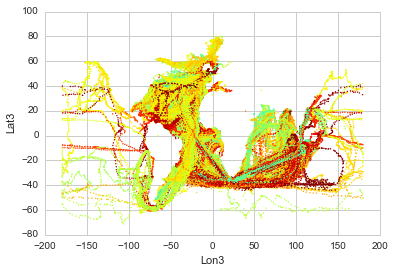

In [6]:
shipdata.plot('Lon3', 'Lat3', c='Year', kind='scatter', 
              lw=0, cmap=pylab.cm.jet, s=2, colorbar=False)

In [32]:
lon = np.array(shipdata['Lon3'])
lat = np.array(shipdata['Lat3'])
c = np.array(shipdata['Year'])
vmin, vmax = np.percentile(c, (5,95))

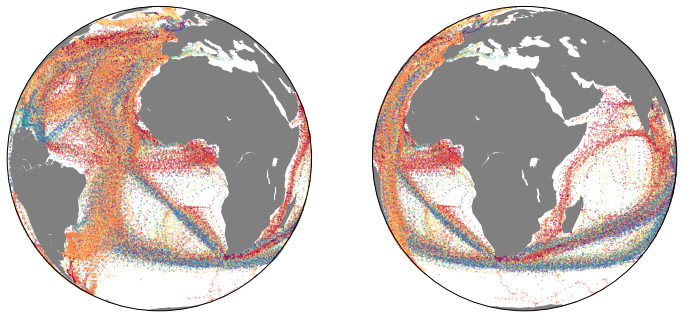

In [41]:
pylab.figure(figsize=(12,6))
pylab.subplot(121)
m = basemap.Basemap(lon_0=-10, projection='geos')
m.fillcontinents(color='0.5')
x, y = m(lon, lat)
sca = m.scatter(x,y, c=c, label='Year',
                vmin=vmin, vmax=vmax, cmap=pylab.cm.Spectral,
                s=2, lw=0, alpha=0.5)

pylab.subplot(122)
m = basemap.Basemap(lon_0=30, projection='geos')
m.fillcontinents(color='0.5')
x, y = m(lon, lat)
sca = m.scatter(x,y, c=c, label='Year',
                vmin=vmin, vmax=vmax, cmap=pylab.cm.Spectral,
                s=2, lw=0, alpha=0.5)

# m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
None

<matplotlib.colorbar.Colorbar instance at 0x1636233b0>

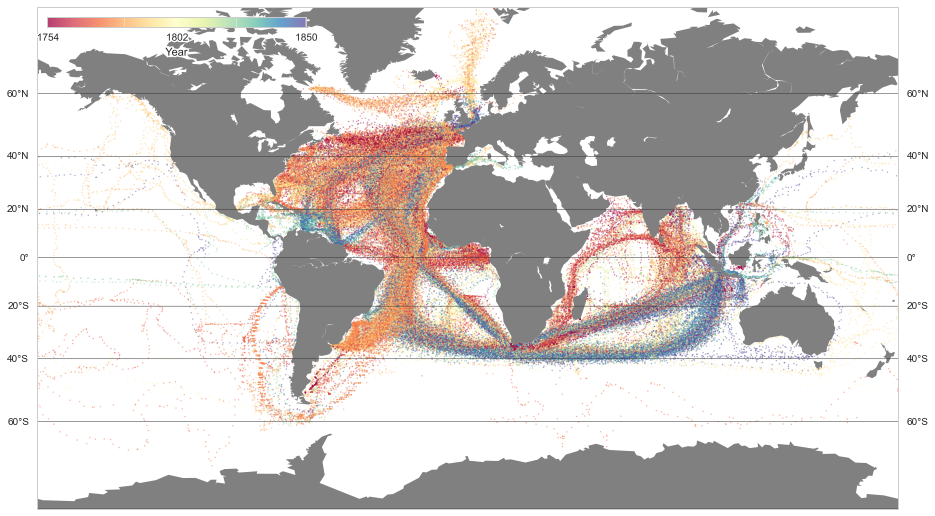

In [87]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
m.fillcontinents(color='0.5')
m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
# m.drawcoastlines(linewidth=0.5)
# m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

x, y = m(lon, lat)
sca = m.scatter(x,y, c=c, label='Year',
                vmin=vmin, vmax=vmax, cmap=pylab.cm.Spectral,
                s=2, lw=0, alpha=0.5)
icolorbar(sca)

In [75]:
x,y = np.linspace(-180,180,361), np.linspace(-80,80,161)
X,Y = np.meshgrid(x,y)
Z = np.histogram2d(lon, lat, bins=(x,y))[0]
Z = np.ma.MaskedArray(np.log10(Z), Z==0)
# X,Y = np.meshgrid(X,Y)

<matplotlib.colorbar.Colorbar instance at 0x15d5e5a70>

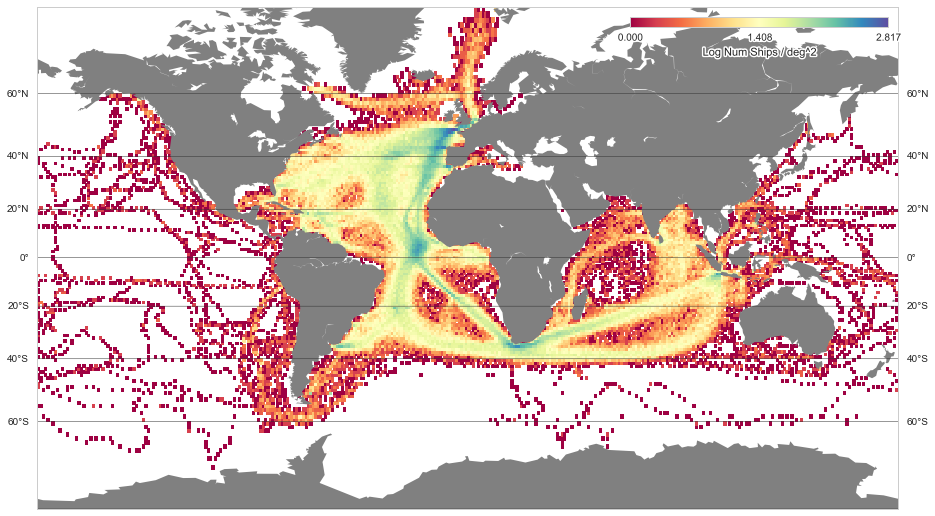

In [88]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80, projection='mill')
m.fillcontinents(color='0.5')
m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
# m.drawcoastlines(linewidth=0.5)
# m.fillcontinents(color='0.8')
# m.drawparallels(np.arange(-80,81,20),labels=[1,1,0,0])
# m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

mx, my = m(X,Y)
pcm = m.pcolormesh(mx,my, Z.T, label='Log Num Ships / deg^2',
                   cmap=pylab.cm.Spectral)
icolorbar(pcm, loc=1)

In [20]:
tmp = shipdata[shipdata['Lon3'].notnull() & shipdata['Lat3'].notnull()]
tmp = pd.DataFrame(np.vstack([tmp['Lat3'], tmp['Lon3']]).T, columns=['lat','lon'])

In [28]:
# geoplotlib.tiles_provider('darkmatter')
geoplotlib.set_window_size(800,800)
geoplotlib.kde(tmp, 2, alpha=128)
geoplotlib.set_bbox(geoplotlib.utils.BoundingBox.WORLD)
geoplotlib.inline(800)

('smallest non-zero count', 4.4777898101688105e-09)
('max count:', 42.119397791020972)


In [37]:
LatLon.LatLon.distance?

In [15]:
def latlon_distance(a,b):
    A = LatLon.LatLon(*a)
    B = LatLon.LatLon(*b)
    try:
        return A.distance(B) # in km
    except:
        print a,b
        raise

tmp = shipdata[shipdata['datenum'] == 657193]
metrics.pairwise_distances(tmp[['lat', 'lon']], metric=latlon_distance)

array([[     0.        ,   4920.69610004,   9767.54719063,  13274.04834131],
       [  4920.69610004,      0.        ,   5587.38056592,   8407.40511157],
       [  9767.54719063,   5587.38056592,      0.        ,   4054.37403477],
       [ 13274.04834131,   8407.40511157,   4054.37403477,      0.        ]])

In [50]:
shipdata.loc[:, 'mindistance'] = 0
shipdata.loc[:, 'meandistance'] = 0
shipdata.loc[:, 'maxdistance'] = 0
udate = np.unique(shipdata['datenum'])
for ud in udate:
    isdate = (shipdata['datenum'] == ud) & (shipdata['Lat3'].notnull()) & (shipdata['Lon3'].notnull())
    tmp = shipdata.loc[isdate, ['lat', 'lon']]
    if len(tmp) > 1:
#         distance = metrics.euclidean_distances(tmp)
        distance = metrics.pairwise_distances(tmp, metric=latlon_distance)
        d = distance[distance>0]
        if len(d) > 0:
            shipdata.loc[isdate, 'mindistance'] = d.min()
            shipdata.loc[isdate, 'meandistance'] = d.mean()
            shipdata.loc[isdate, 'maxdistance'] = d.max()
#         if distance.max() > 0:
#             print distance
#             print tmp

In [52]:
shipdata[['datenum','mindistance', 'meandistance', 'maxdistance']].describe()

,datenum,mindistance,meandistance,maxdistance
count,280280.000000,280280.000000,280280.000000,280280.000000
mean,656916.625467,768.855541,5831.724525,12150.396105
std,11675.639825,1455.094317,2749.545893,5464.749518
min,606956.000000,0.000000,0.000000,0.000000
25%,647883.000000,21.393418,4545.631782,10058.556312
50%,654155.000000,268.437644,6399.604535,13554.701941
75%,668905.000000,897.473756,7714.422799,16033.725351
max,677369.000000,18357.244870,18357.244870,19991.480800


In [ ]:
pd.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138a5fc10>]], dtype=object)

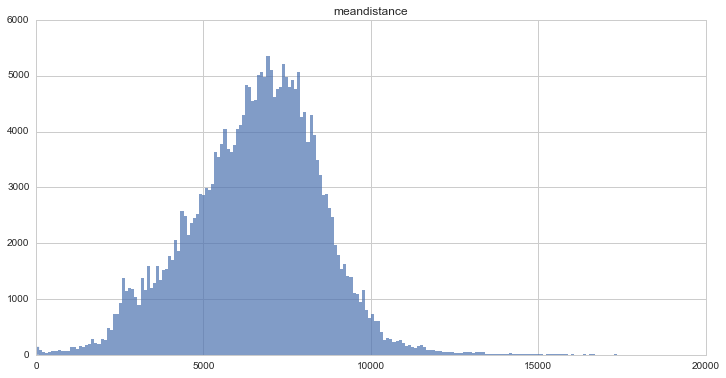

In [57]:
shipdata[shipdata['meandistance']>0].hist('meandistance', bins=200, lw=0, alpha=0.7,
                                          figsize=(12,6), )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x137d29310>]], dtype=object)

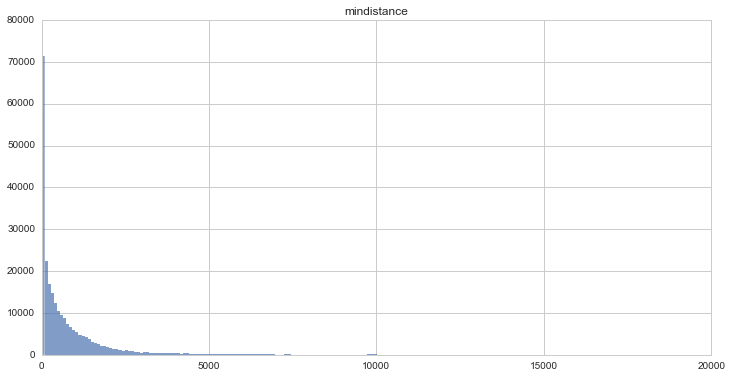

In [68]:
shipdata[shipdata['mindistance']>0].hist('mindistance', bins=200, lw=0, alpha=0.7,
                                          figsize=(12,6), )

10158


<matplotlib.colorbar.Colorbar instance at 0x13c5e9950>

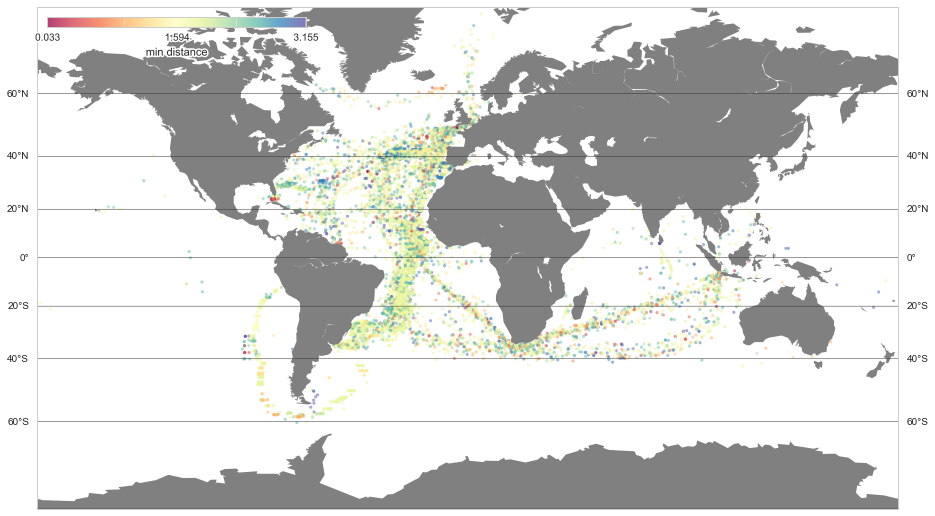

In [63]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
m.fillcontinents(color='0.5')
m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
# m.drawcoastlines(linewidth=0.5)
# m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

x, y = m(lon, lat)
c = np.array(shipdata['mindistance'])
ii = np.where((c > 0) & (c < 1.6*2))[0]
print len(ii)
sca = m.scatter(x[ii], y[ii], c=c[ii], label='min distance',
                cmap=pylab.cm.Spectral,
                s=10, lw=0, alpha=0.5)
icolorbar(sca)

202


<matplotlib.colorbar.Colorbar instance at 0x13d24f440>

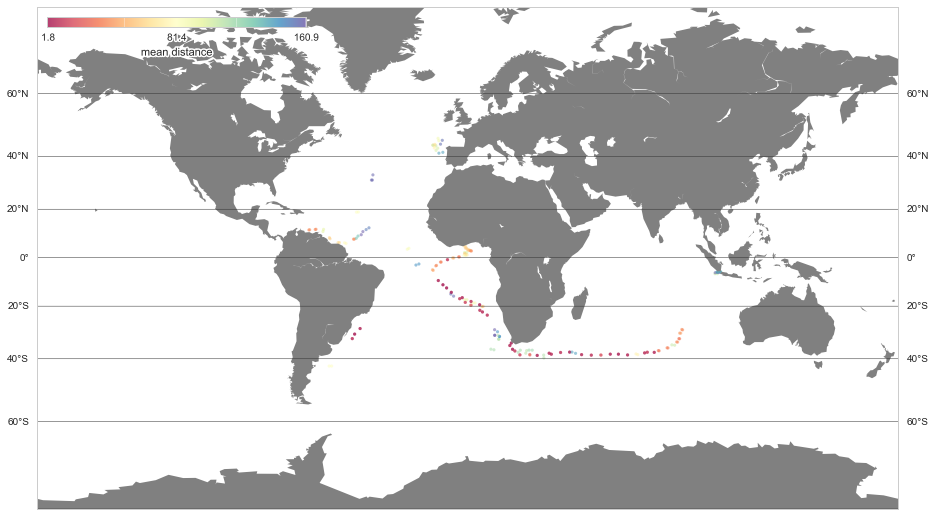

In [67]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
m.fillcontinents(color='0.5')
m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
# m.drawcoastlines(linewidth=0.5)
# m.drawmeridians(np.arange(0,360,60),labels=[0,0,0,1])

x, y = m(lon, lat)
c = np.array(shipdata['meandistance'])
ii = np.where((c > 0) & (c < 160.934))[0]
print len(ii)
sca = m.scatter(x[ii], y[ii], c=c[ii], label='mean distance',
                cmap=pylab.cm.Spectral,
                s=10, lw=0, alpha=0.5)
icolorbar(sca)

American 200
British 88559
Danish 62
Dutch 125977
French 10632
Hamburg 68
Spanish 54082
Swedish 700


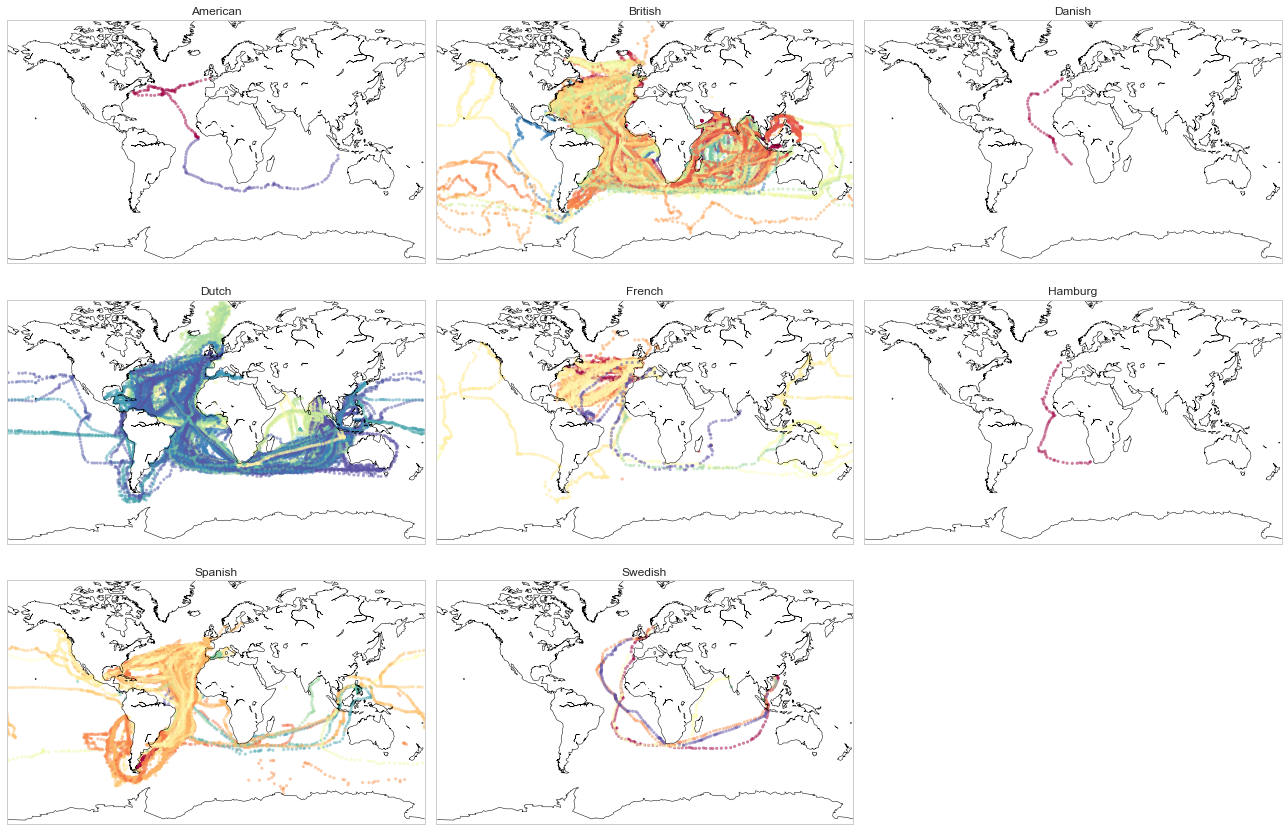

In [82]:
pylab.figure(figsize=(18,12))

c = np.array(shipdata['Year'])
nationality = np.array(shipdata['nat'])
unat = np.unique(nationality)
for i, nat in enumerate(unat):
    pylab.subplot(3, 3, i+1)
    pylab.title(nat)
    m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                        urcrnrlon=180, urcrnrlat=80,
                        projection='mill')
#     m.fillcontinents(color='0.5')
    m.drawcoastlines(linewidth=0.5)
#     m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)
    
    ii = np.where(nationality == nat)[0]
    print nat, len(ii)
    sca = m.scatter(x[ii], y[ii], c=c[ii], label='{} Year'.format(nat),
                    cmap=pylab.cm.Spectral,
                    s=10, lw=0, alpha=0.5)
#     icolorbar(sca)
#     break
pylab.tight_layout()

In [167]:
def make_mapdict(arr):
    mapdict = {}
    for ua in np.unique(arr):
        ii = np.where((arr == ua) & 
                      (shipdata['Lat3'].notnull()) & 
                      (shipdata['Lon3'].notnull()) )[0]
        if len(ii) <= 1:
            mapdict[ua] = [None, None]
            continue
        jj = np.argsort(shipdata.loc[ii,'date'])
        mapdict[ua] = shipdata.loc[ii[jj][0], ['lat','lon']].tolist()
    return mapdict

fromdict = make_mapdict(shipdata['from'])
todict = make_mapdict(shipdata['to'])
#     print ufrom, len(ii), fromdict[ufrom]
#     break

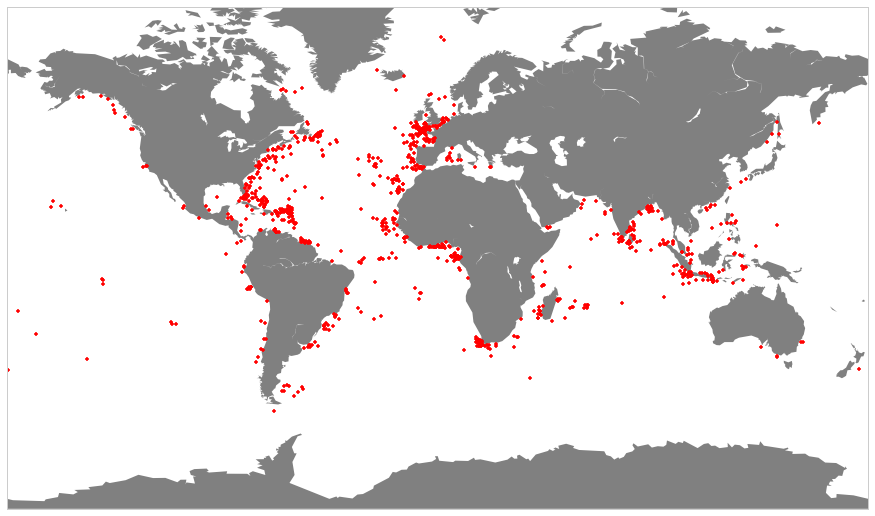

In [193]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
m.fillcontinents(color='0.5')
# m.drawparallels(np.arange(-80,81,20), labels=[1,1,0,0], dashes=[], color='0.2', linewidth=0.5)

for name,(lat, lon) in fromdict.iteritems():
    if (lat == lon == None):
#         print name
        continue
    x, y = m(lon, lat)
    m.plot(x, y, '.', color='r')
#     text(x, y, name.decode('ascii', 'ignore').capitalize(), ha='center', va='top', outline=True)
#     break

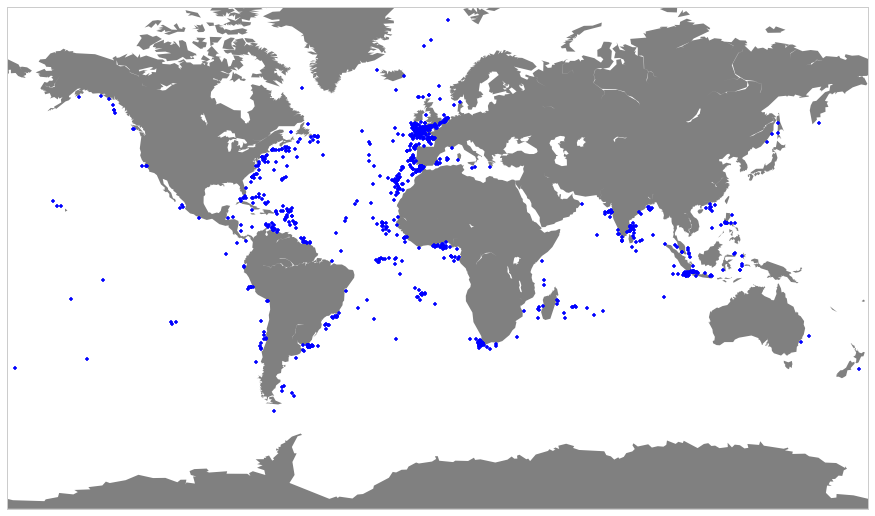

In [194]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
m.fillcontinents(color='0.5')

for name,(lat, lon) in todict.iteritems():
    if (lat == lon == None):
        continue
    x, y = m(lon, lat)
    m.plot(x, y, '.', color='b')

In [229]:
dontrun = {}
run = {}

In [297]:
for from_name, (from_lat, from_lon) in fromdict.iteritems():
    for to_name, (to_lat, to_lon) in todict.iteritems():
        key = (from_name, to_name)
        if key in dontrun:
            continue
        if key not in run:
            ii = np.where((shipdata['from'] == from_name) & 
                          (shipdata['to'] == to_name) )[0]
            if len(ii) <= 1:
                dontrun[key] = None
                continue
            run[key] = [ii, [from_lon, to_lon], [from_lat, to_lat]]
        
        if (len(run) % 10) == 0:
            print len(run)

/Users/ajmendez/.local/canopy/User/lib/python2.7/site-packages/pandas/core/ops.py:648: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  result = lib.scalar_compare(x, y, op)


KeyboardInterrupt: 

In [298]:
len(run), len(dontrun), len(dontrun)*1.0/(len(fromdict)*len(todict))

(83, 25975, 0.027389619044405452)

<matplotlib.colorbar.Colorbar instance at 0x1417ae2d8>

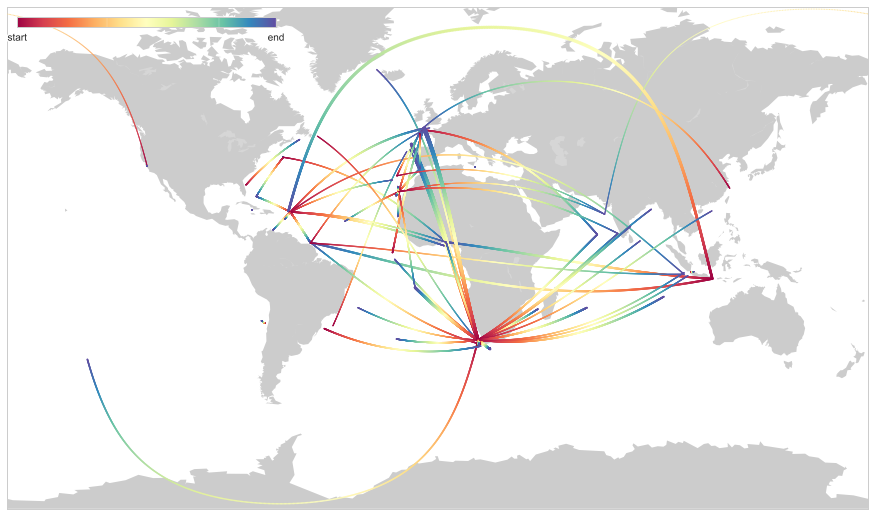

In [299]:
pylab.figure(figsize=(18,9))
m = basemap.Basemap(llcrnrlon=-180, llcrnrlat=-80,
                    urcrnrlon=180, urcrnrlat=80,
                    projection='mill')
m.fillcontinents(color='k', alpha=0.2)

ngc = 1000
npts = np.max([len(i[0]) for i in run.itervalues()])
for key, (index, lon, lat) in run.iteritems():
    if (lon[0] == None) or (lon[1] == None):
        continue
    
    x,y = m.gcpoints(lon[0], lat[0], lon[1], lat[1], ngc)
    sca = m.scatter(x, y, c=np.linspace(0,1,ngc), alpha=0.9, lw=0, s=1+len(index)*10.0/npts, 
                    cmap=pylab.cm.Spectral, vmin=0, vmax=1, zorder=4)
    # show number
#     sca = m.scatter(x,y, c=np.ones(ngc)*len(index), alpha = 0.75, 
#                     lw=0, s=3, vmin=0, vmax=npts, cmap=pylab.cm.Spectral)
icolorbar(sca, ticks=[0,1], ticknames=['start', 'end'])

In [292]:
fromdict

{"'t nieuwe diep": [-10.2667, -26.199999999999999],
 '(gilolo) halmahira': [4.7333300000000005, 133.10299999999998],
 'acapulco': [16.466699999999999, -99.883300000000006],
 'acara': [4.8499999999999996, 4.5166699999999995],
 'accra': [4.5333300000000003, 1.55],
 'accrah': [0.51666699999999999, 5.3533300000000006],
 'accraw': [4.7666699999999995, 0.26666699999999999],
 'achean': [5.2999999999999998, 93.033299999999997],
 'achean head': [6.2000000000000002, 94.433300000000003],
 'achean head, sumatra': [5.8333300000000001, 95.2333],
 'acheen': [7.2166699999999997, 94.183300000000003],
 'acheen (sumatra)': [5.75, 94.420000000000002],
 'acheen head, sumatra': [5.5333300000000003, 93.0167],
 'achin road': [5.5300000000000002, 95.5],
 'adelaide': [-35.916699999999999, 135.09999999999999],
 'aden': [12.716699999999999, 46.816699999999997],
 'afrika': [4.4833300000000005, 0.93000000000000005],
 'aguadilla': [19.166699999999999, -67.466700000000003],
 'akijab': [19.449999999999999, 92.16670000

In [ ]:
clean = {'achean':['achean head','achean head, sumatra', 'acheen', 'acheen (sumatra)', 'achin road'],
         'amboyna':['ambon'],
         'anjango': ['anjango road', 'anjengo'],
         'bangoewangie': ['bangowangie','banjoemangie','banjoemangie','banjoewangi','banjouwangie','banjoewangie','banjoewangi'],
         'barbados':['barbados (cruising)'],
         '':[''],
         '':[''],
         '':[''],
         
        
        
        }